In [1]:
import pandas as pd
import numpy as np
import networkx as nx

from tqdm import tqdm
import collections

import seaborn as sns
import sklearn
from matplotlib import pyplot as plt

In [2]:
SEED = 224
DISPLAY = True
EXPORT = True
RECOMPUTE = False

# Import (with minimal preprocessing)

In [3]:
if (RECOMPUTE):
    orig_dat_1 = pd.read_excel("data/online_retail_II.xlsx",
                               sheet_name="Year 2009-2010", index_col=None,
                               keep_default_na=True, parse_dates=['InvoiceDate'])
    orig_dat_2 = pd.read_excel("data/online_retail_II.xlsx",
                               sheet_name="Year 2010-2011", index_col=None,
                               keep_default_na=True, parse_dates=['InvoiceDate'])
    print(len(orig_dat_1) + len(orig_dat_2), len(orig_dat))
    
    orig_dat = (pd.concat([orig_dat_1, orig_dat_2])
                  .reset_index()
                  .drop('index', axis=1)
                  .rename(columns={"Customer ID":"CustomerID"})
               )
    
    if (EXPORT):
        orig_dat.to_csv("online_retail_II.csv", index=False)
        
else:
    orig_dat = pd.read_csv("data/online_retail_II.csv", parse_dates=['InvoiceDate'])

assert len(orig_dat) == 1067371

In [4]:
# Remember to unzip data in data
dat = orig_dat.copy()
dat.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
dat.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
# Note that Description is ONLY NULL when customer is null
orig_dat[pd.isnull(orig_dat.Description)].CustomerID.unique()

array([nan])

In [7]:
dat[dat['CustomerID'] == 17850.0] # one customer bought 2827 things! (apparently most were returns though)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
12150,490373,85014B,RED/WHITE DOTS RUFFLED UMBRELLA,6,2009-12-05 12:28:00,4.95,17850.0,United Kingdom
12151,490373,15056BL,EDWARDIAN PARASOL BLACK,6,2009-12-05 12:28:00,4.95,17850.0,United Kingdom
12152,490373,79323P,PINK CHERRY LIGHTS,4,2009-12-05 12:28:00,5.45,17850.0,United Kingdom
12153,490373,79323W,WHITE CHERRY LIGHTS,4,2009-12-05 12:28:00,5.45,17850.0,United Kingdom
12154,490373,22352,LUNCHBOX WITH CUTLERY RETROSPOT,12,2009-12-05 12:28:00,2.10,17850.0,United Kingdom
12155,490373,21869,POTTING SHED COFFEE MUG,12,2009-12-05 12:28:00,1.06,17850.0,United Kingdom
12156,490373,21868,POTTING SHED TEA MUG,12,2009-12-05 12:28:00,1.06,17850.0,United Kingdom
12157,490373,21733,RED HANGING HEART T-LIGHT HOLDER,12,2009-12-05 12:28:00,2.55,17850.0,United Kingdom
12158,490373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,12,2009-12-05 12:28:00,2.55,17850.0,United Kingdom
12159,490373,82486,WOOD S/3 CABINET ANT WHITE FINISH,6,2009-12-05 12:28:00,6.95,17850.0,United Kingdom


In [8]:
# don't care about transactions with no item or no customer
dat = dat.dropna(subset=['StockCode', 'CustomerID'], how='any', axis=0) 
dat.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [9]:
dat.sort_values('Price') # A lot of the largest/smallest prices come from manual/discount

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
248583,513416,22423,REGENCY CAKESTAND 3 TIER,5,2010-06-24 12:34:00,0.00,13089.0,United Kingdom
392008,527084,22630,DOLLY GIRL LUNCH BOX,64,2010-10-14 15:33:00,0.00,14646.0,Netherlands
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.00,17231.0,United Kingdom
612250,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.00,17560.0,United Kingdom
945865,572893,21208,PASTEL COLOUR HONEYCOMB FAN,5,2011-10-26 14:36:00,0.00,18059.0,United Kingdom
887286,568384,M,Manual,1,2011-09-27 09:46:00,0.00,12748.0,United Kingdom
1004540,577129,22464,HANGING METAL HEART LANTERN,4,2011-11-17 19:52:00,0.00,15602.0,United Kingdom
1005014,577168,M,Manual,1,2011-11-18 10:42:00,0.00,12603.0,Germany
823515,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.00,14911.0,EIRE
713074,553000,47566,PARTY BUNTING,4,2011-05-12 15:21:00,0.00,17667.0,United Kingdom


In [10]:
# Get rid of some of these manual codes
dat = dat[~dat.StockCode.isin(['M', 'POST', 'D', 'DOT', 'CRUK', 'C2', 'BANK CHARGES', 'ADJUST', 'ADJUST2', 'TEST001'])]
dat.sort_values('Price')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
682503,550188,22636,CHILDS BREAKFAST SET CIRCUS PARADE,1,2011-04-14 18:57:00,0.0,12457.0,Switzerland
471776,533822,22845,VINTAGE CREAM CAT FOOD CONTAINER,1,2010-11-19 09:40:00,0.0,12647.0,Germany
972255,574920,23480,MINI LIGHTS WOODLAND MUSHROOMS,1,2011-11-07 16:34:00,0.0,13985.0,United Kingdom
471775,533822,22846,BREAD BIN DINER STYLE RED,1,2010-11-19 09:40:00,0.0,12647.0,Germany
964822,574469,22385,JUMBO BAG SPACEBOY DESIGN,12,2011-11-04 11:55:00,0.0,12431.0,Australia
512240,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
655649,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
248583,513416,22423,REGENCY CAKESTAND 3 TIER,5,2010-06-24 12:34:00,0.0,13089.0,United Kingdom
612250,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
276858,516304,22690,DOORMAT HOME SWEET HOME BLUE,6,2010-07-19 13:13:00,0.0,14025.0,United Kingdom


In [30]:
# Remove cancellations
dat = dat[~dat.Invoice.str.startswith('C')]

In [11]:
# end preprocessing

In [31]:
len(orig_dat), len(dat)

(1067371, 802714)

# Build graphs with node and edge features

In [12]:
bins = pd.date_range(start=dat.InvoiceDate.min(), end=dat.InvoiceDate.max(), freq='W-TUE')
bins, len(bins), dat.InvoiceDate.min(), dat.InvoiceDate.max()

(DatetimeIndex(['2009-12-01 07:45:00', '2009-12-08 07:45:00',
                '2009-12-15 07:45:00', '2009-12-22 07:45:00',
                '2009-12-29 07:45:00', '2010-01-05 07:45:00',
                '2010-01-12 07:45:00', '2010-01-19 07:45:00',
                '2010-01-26 07:45:00', '2010-02-02 07:45:00',
                ...
                '2011-10-04 07:45:00', '2011-10-11 07:45:00',
                '2011-10-18 07:45:00', '2011-10-25 07:45:00',
                '2011-11-01 07:45:00', '2011-11-08 07:45:00',
                '2011-11-15 07:45:00', '2011-11-22 07:45:00',
                '2011-11-29 07:45:00', '2011-12-06 07:45:00'],
               dtype='datetime64[ns]', length=106, freq='W-TUE'),
 106,
 Timestamp('2009-12-01 07:45:00'),
 Timestamp('2011-12-09 12:50:00'))

In [13]:
import networkx as nx
import os

class TemporalGraph:
    
    def __init__(self, node_ordering, index):
        self.frames = {}
        self.index = index # save this as an accessor to which bins exist
        self.node_ordering = node_ordering
    
    def add_frame(self, ind, frame):
        self.frames[ind] = frame
        
    def get_frame(self, ind):
        """ Returns a copy of the frame at the index.
        """
        return self.frames[ind].copy()
        
    def read_gpickles(self, directory):
        for ind_path in os.listdir(directory):
            ind = os.path.basename(ind_path).split(".")[0]
            self.frames[ind] = nx.read_gpickle(os.path.join(directory, ind_path))
            
    def write_gpickles(self, directory):
        if not os.path.isdir(directory):
            os.mkdir(directory)
            
        for ind, frame in self.frames.items():
            nx.write_gpickle(frame, os.path.join(directory, "%s.pkl" % ind))

## Some descriptions are misspelled/updated later.
We'll keep the last occurrence.

In [14]:
duplicated = dat[['StockCode', 'Description']].drop_duplicates().sort_values('StockCode')
duplicated[duplicated.duplicated(subset=['StockCode'], keep=False)]

,StockCode,Description
548898,15058A,BLUE POLKADOT GARDEN PARASOL
67142,15058A,BLUE WHITE SPOTS GARDEN PARASOL
67188,15058B,PINK WHITE SPOTS GARDEN PARASOL
461044,15058B,PINK POLKADOT GARDEN PARASOL
10462,16011,ANIMAL STICKERS
119710,16011,ANIMAL STICKERS
314800,16012,FOOD/DRINK SPONGE STICKERS
4157,16012,FOOD/DRINK SPUNGE STICKERS
710756,16151A,FLOWERS HANDBAG blue and orange
181581,16151A,FLOWER DES BLUE HANDBAG/ORANG HANDL


In [15]:
def create_frame(dat):
    G = nx.Graph()
    
    #Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
    #   'Price', 'CustomerID', 'Country'],
    #  dtype='object')
        
    custData = dat[['CustomerID', 'Country']].drop_duplicates(subset=['CustomerID'], keep='last')
    stockData = dat[['StockCode', 'Description']].drop_duplicates(subset=['StockCode'], keep='last')
    
    assert len(custData) == len(custData.CustomerID.unique())
    assert len(stockData) == len(stockData.StockCode.unique())
    
    for i, stock in stockData.iterrows():
        G.add_node(stock.StockCode,
                   description=stock.Description)
    
    for i, customer in custData.iterrows():
        G.add_node(customer.CustomerID,
                   country=customer.Country)
        
    for i, row in dat.iterrows():
        G.add_edge(row.StockCode,
                   row.CustomerID,
                   key=row.Invoice,
                   quantity=row.Quantity,
                   date=row.InvoiceDate,
                   price=row.Price) # sometimes price changes, sale?
        
    return G

In [17]:
TG = TemporalGraph(None, None) #node_ordering, bins)

path = "data/temporal_bipartite_snapshot_no_node_ordering"

if (not os.path.isdir("data/temporal_bipartite_snapshot_no_node_ordering") or RECOMPUTE):
    bin_dat = dat[dat.InvoiceDate < bins[0]]
    frame = create_frame(bin_dat)
    TG.add_frame(dat.InvoiceDate.min(), frame)

    for i in range(len(bins)):
        start = bins[i]
        if i+1 == len(bins):
            end = dat.InvoiceDate.max()
        else:
            end = bins[i+1] + 1

        bin_dat = dat[(dat.InvoiceDate >= start) & (dat.InvoiceDate < end)]
        frame = create_frame(bin_dat)
        TG.add_frame(start, frame)
        print(start, end, len(bin_dat))
        
else:
    TG.read_gpickles("data/temporal_bipartite_snapshot_no_node_ordering")

In [18]:
if (EXPORT):
    TG.write_gpickles("data/temporal_bipartite_snapshot_no_node_ordering")

# Params

In [19]:
# bipartite
node_id = ['StockCode', 'CustomerID', ]
edge_features = ['Invoice', 'Quantity', 'InvoiceDate',]
nodes_features = ['Description', 'Price', 'Country']

# stockcodes only
node_id = ['StockCode',]
edge_features = ['Invoice', 'Quantity', 'InvoiceDate', 'CustomerID',  'Country']
nodes_features = ['Description', 'Price', ]

# bipartite
node_id = ['CustomerID', ]
edge_features = ['StockCode', 'Description', 'Price', 'Invoice', 'Quantity', 'InvoiceDate',]
nodes_features = ['Country']

In [20]:
# boolean settings
params = [
    ("directed", "undirected"), # does direction matter?
    ("stock_and_customer", "stock_only", "customer_only"), # bipartite or contracted bipartite
    ("multi", "simple"), # use quantity as weights/multiedges?
    ("snapshot", "cumulative") # snapshot = only purchases made in time window, cumulative = sum up
]

2684


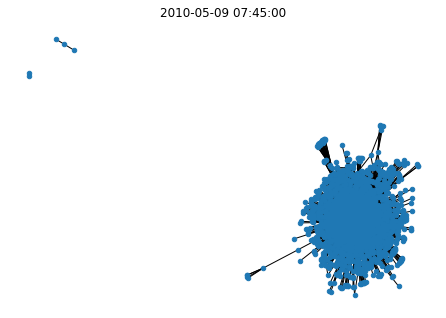

3092


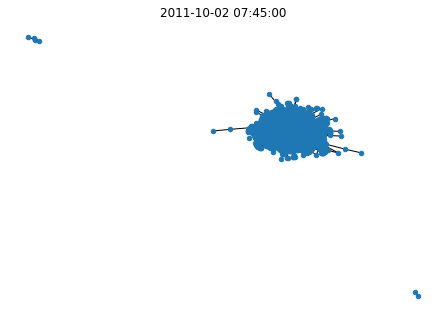

2508


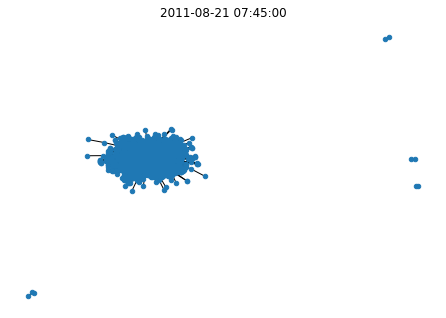

1000


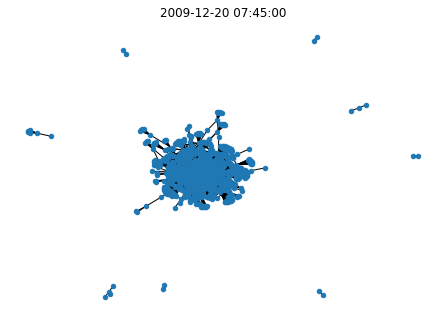

2354


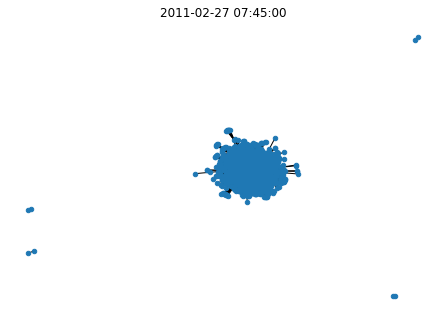

2403


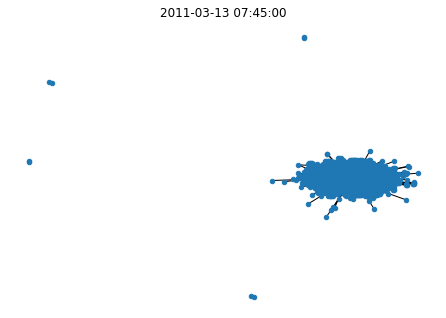

2650


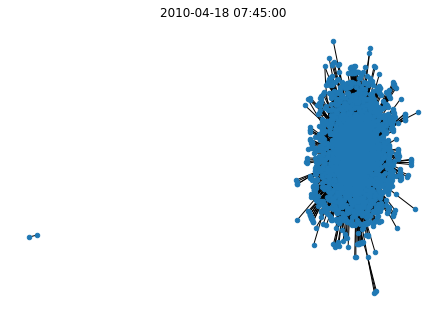

2228


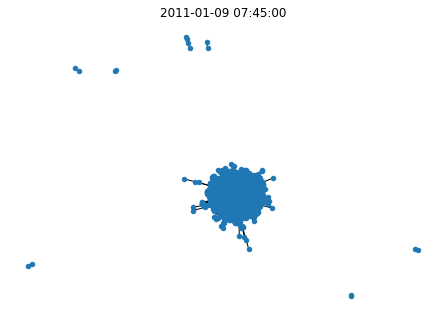

2634


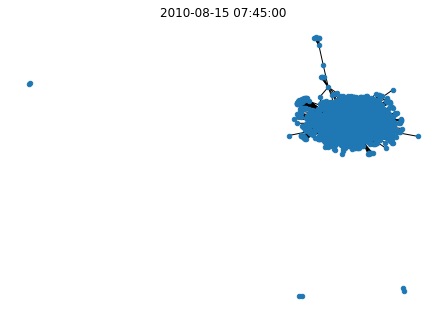

2572


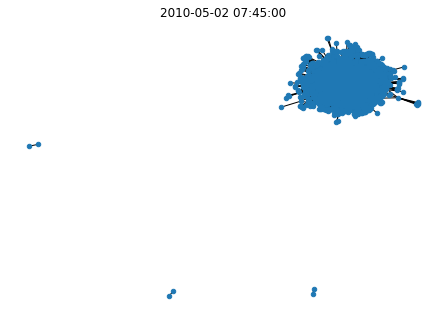

2512


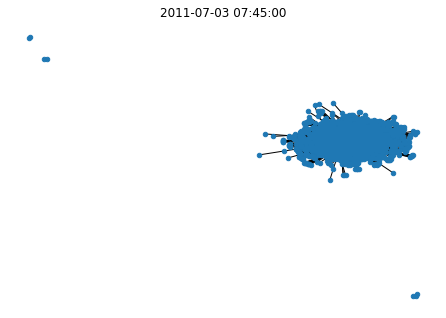

3125


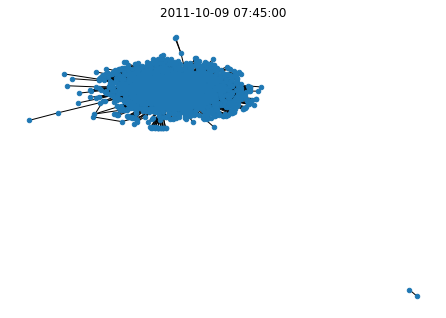

3376


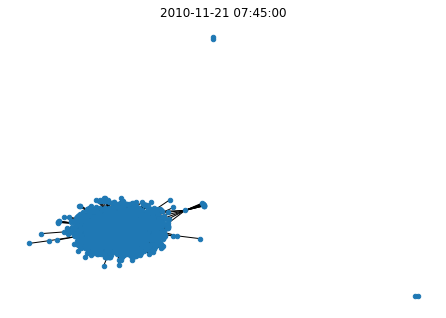

2520


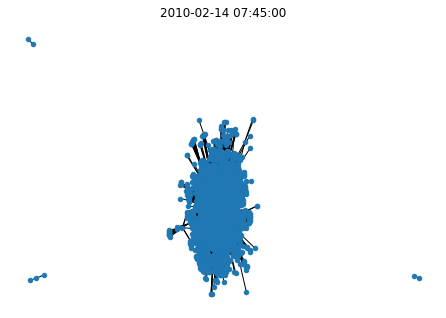

2335


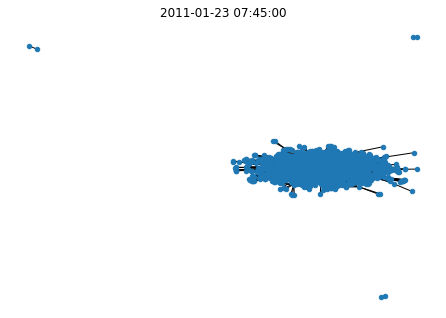

2254


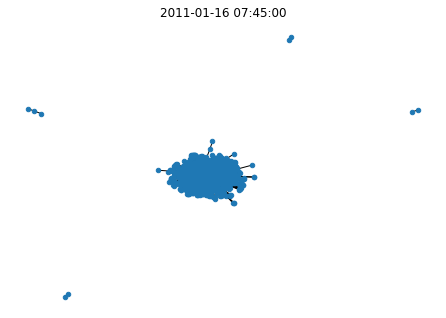

2565


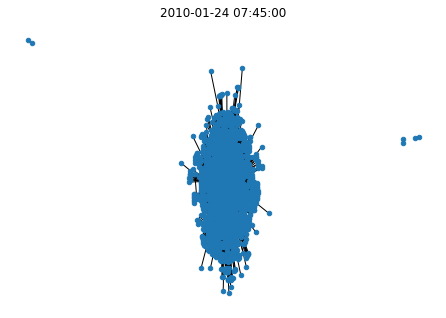

3460


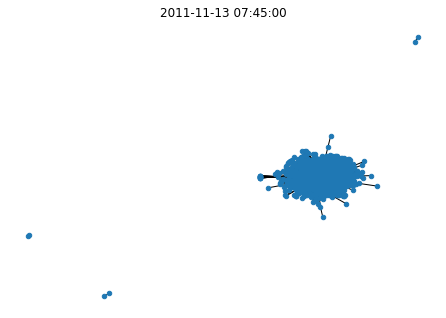

2622


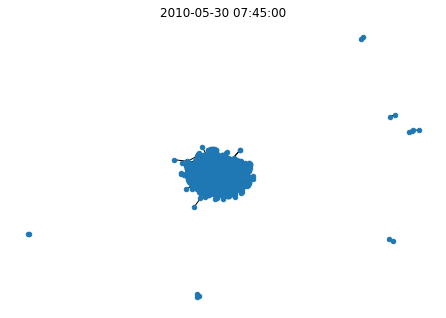

2388


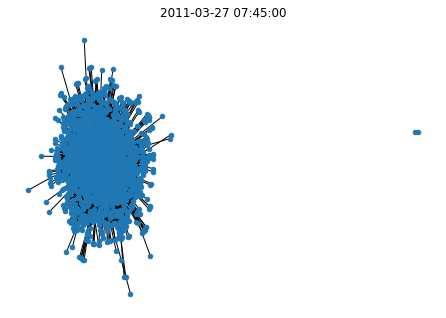

2322


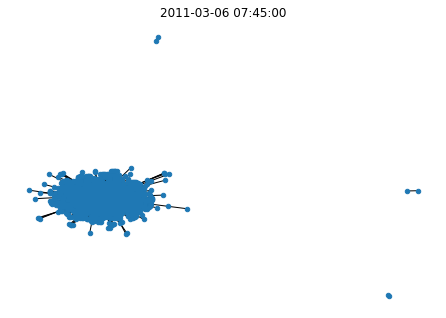

2583


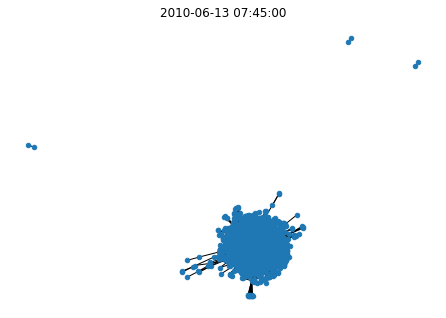

2634


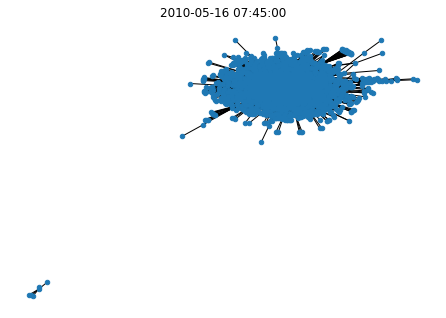

2474


KeyboardInterrupt: 

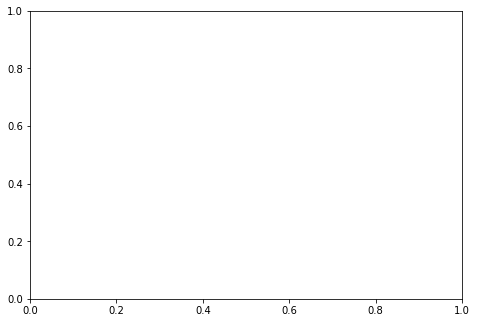

In [24]:
if (DISPLAY):
    for ind, frame in TG.frames.items():
        # Slow - only draw subgraphs
        print(len(frame))
        nx.draw(frame, node_size=20)
        plt.title(str(ind))
        plt.show()